In [7]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA

import itertools
import json

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10) - <b> define shared list of combinations </b>
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [2]:
# ranking is based on distance similarity
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    # reset_index -> index+1 becomes the ranking
    output.reset_index(inplace=True)
    
    return output

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [4]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [5]:
def plotData(seeds, candidates, components, centroids = None):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')
    
    if centroids is not None:
        for c in centroids:
            plt.scatter(c[0], c[1], marker='o', color='black')

In [6]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [19]:
header = ['{}'.format(i) for i in range(1,9)]

# Run tests with fixed combinations

In [13]:
allseeds = list(map(str, pd.read_csv('../data-seed/fashion/user.csv', sep='\t')['screen_name']))
combinations = json.load(open('combinations.json', 'rb'))

In [14]:
allseeds

['edwardcordobab',
 'cortomoltedo',
 'aincontri',
 'angelosfrentzos',
 'andrea_pompilio',
 'maisonalbino',
 '10acompany',
 'arthurarbesser',
 'alabmilano',
 'angelosbratis',
 'aujourlejour_',
 'amenstyle',
 'arnoldoebattois',
 '2w2m',
 '1darklevel',
 'aquilanorimondi',
 'abrahamkhangul1',
 'alessia_xoccato']

In [10]:
len(combinations)

10

In [12]:
domain = 'fashion'
datapath = '../data-seed/{}/'.format(domain)
path = 'random-test/test-network-features/'.format(domain)

In [47]:
# define function to apply the same analysis to all the datasets
def computePerformance(allseeds, comb, data, network_type):
    
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []

    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['username']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)
    prec_20 = []
    
    for c in comb:
        effective_seeds = [x.lower() for x in comb[c]] #lower case for usernames
        good_candidates = list(set(allseeds)-(set(effective_seeds)))
        if len(good_candidates) == 8:
            seedsVectors = data[data['username'].isin(effective_seeds)]
            centroid = computeCentroid(seedsVectors, header)
            candidates = data[~data['username'].isin(effective_seeds)]

            r = candidatesRanking(candidates, centroid, header)
            r['good'] = r.apply(lambda x: True if x['username'] in good_candidates else False, axis=1)

            y = cumulativeGoodCandidates(r)
            ysum = ysum + y

            for index, candidate in r[r['good'] == True].iterrows():
                username = candidate['username']
                candidates_ranking[username].append(index+1)

            for index, candidate in r.iterrows():
                username = candidate['username']
                all_ranking[username].append(index+1)

            prec_20.append(cumulativeGoodCandidates(r[:20])[19])

    y_avg = ysum.astype(float)/(len(combinations)-2)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for {} network'.format(network_type))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 8], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,9))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))
              
    return [y_avg, candidates_ranking, all_ranking]

In [17]:
test = 1

seed_data = pd.read_csv(datapath+'/user.csv', sep='\t')
seed_data['usertype'] = 'seed'

# test ids needed to filter the mentioned/following/followed users (they are not included in the ranking)
testusers = pd.read_csv('../data-random/user.csv', sep='\t')

## Hashtags Network Test - 1

Average P@20: 5.50


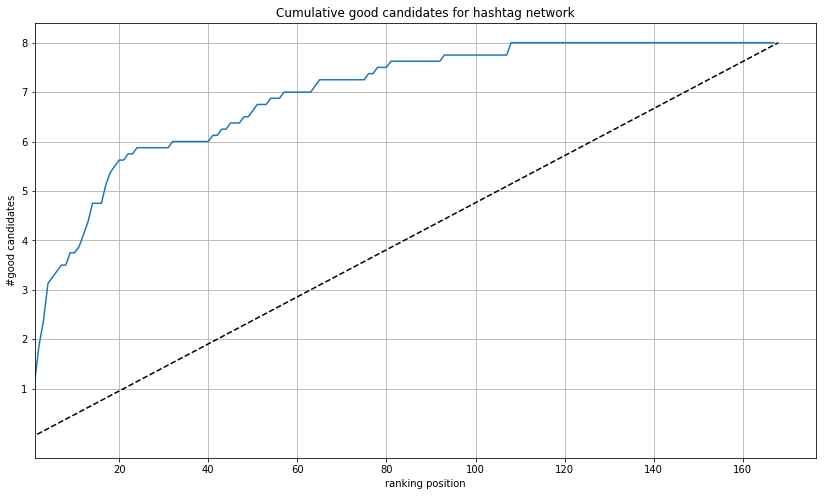

In [48]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'h_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
data = pd.read_csv(path+'h_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)

perf_tag, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'hashtag')

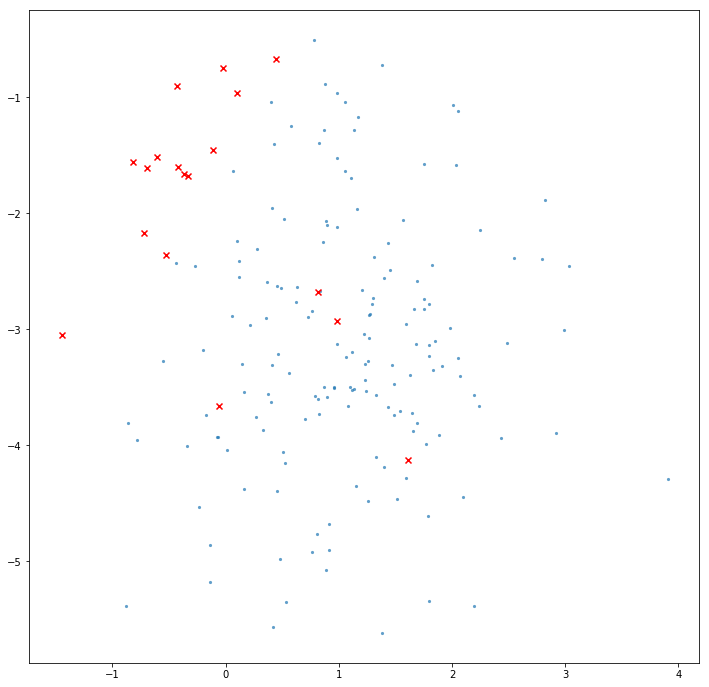

In [30]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Mention Network Test - 1

Average P@20: 1.00


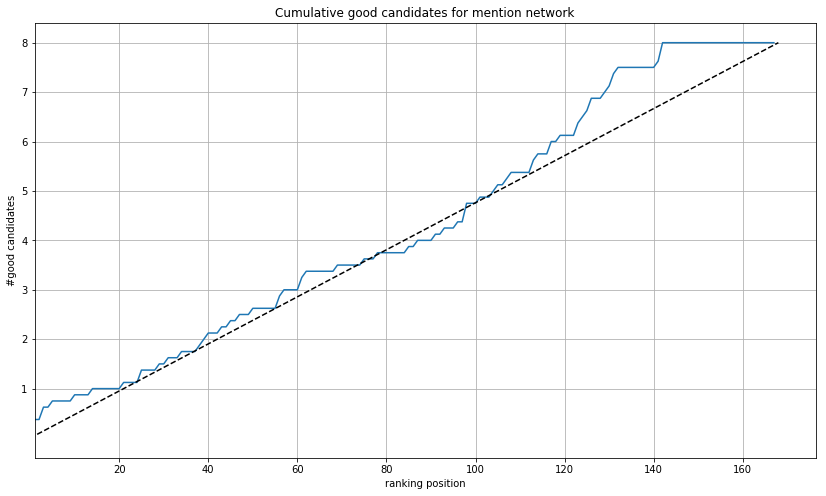

In [56]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'m_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
userdata = userdata[userdata['id_node'].isin(['seed', 'user'])]

data = pd.read_csv(path+'m_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)

data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header
data['id_user'] = data['id_user'].astype(int)

# keeps only seeds and test users for the evaluation
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

perf_mention, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'mention')

In [140]:
result = []
for id_user in sorted(candidate_rank, key=candidate_rank.get):
    result.append(tuple(
        (seed_data[seed_data['id_user'] == int(id_user)]['screen_name'].values[0], np.mean(candidate_rank[id_user]))
    ))

In [141]:
pd.DataFrame(result, columns=['screen_name', 'ranking']).sort_values(by='ranking')

,screen_name,ranking
0,katie_martin_fx,1.347826
4,justinwolfers,2.048387
1,economisthulk,2.326923
2,dsquareddigest,2.644068
3,reformedbroker,3.481481
6,firoozye,4.235294
5,economistmeg,5.687500
10,howardlindzon,8.588235
9,laurenlacapra,9.660377
7,bill_easterly,13.097561


In [ ]:
for id_user in candidate_rank:
    print (id_user, candidate_rank[id_user])

In [142]:
allresult = []
for id_user in all_rank:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_rank[id_user]))
    ))

In [145]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if str(x['id_user']) in allseeds else 'random', axis=1)

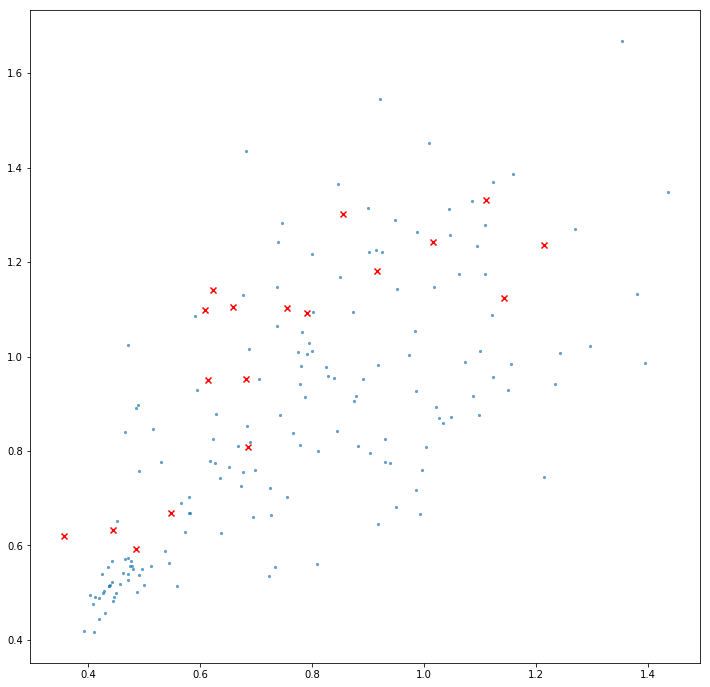

In [57]:
plotData(data[data['usertype_x'] == 'seed'], data[data['usertype_x']=='user'], header)

## Following Network Test - 1

Average P@20: 3.38


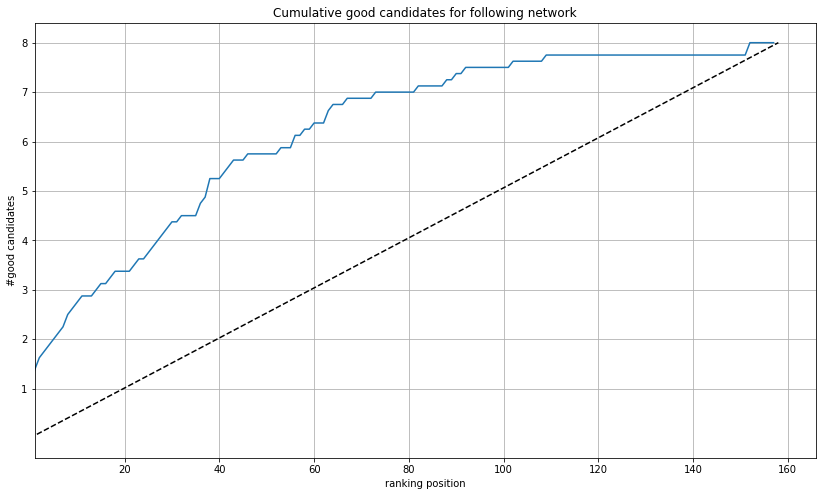

In [58]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_following_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_following.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_following, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'following')

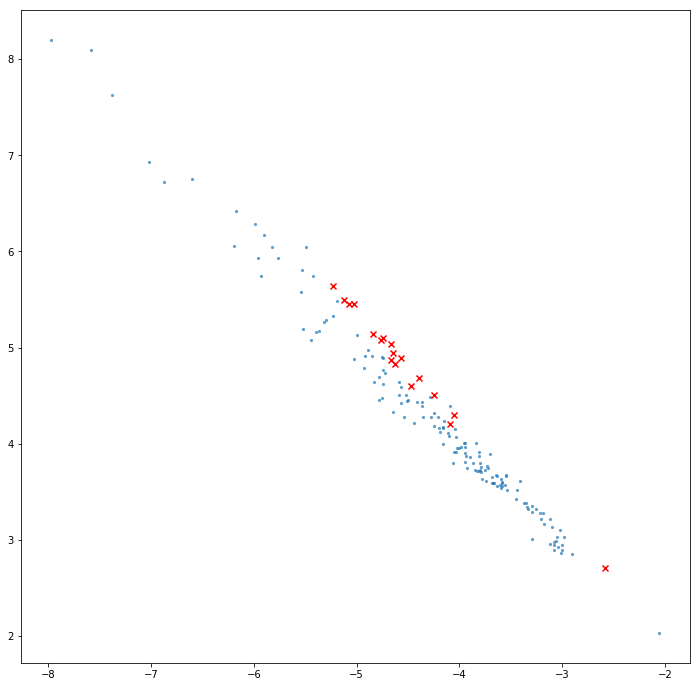

In [59]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

In [44]:
# these are missing because they have no following, so they are not present in the network
set(testusers[testusers['n_test']==1]['id_user']) - set(data['id_user'])

{519,
 3077,
 4562,
 9258192,
 9656292,
 19812908,
 36958712,
 62985293,
 193280501,
 860061325}

In [126]:
for id_user in candidates_ranking:
    print (id_user, candidates_ranking[id_user])

36361027 [30, 62, 37, 29, 44, 46, 50, 58, 19, 36, 39, 34, 31, 45, 53, 61, 40, 13, 58, 33, 53, 45, 47, 59, 58, 37, 47, 46, 29, 24, 61, 42, 31, 39, 42, 50, 29, 61, 58, 33, 58, 65, 39, 44, 51, 54, 41, 45, 41, 54, 54, 23, 45]
104952689 [39, 52, 66, 42, 46, 60, 62, 40, 48, 17, 47, 49, 53, 45, 57, 51, 43, 49, 64, 61, 38, 60, 54, 16, 50, 47, 51, 20, 29, 56, 47, 36, 43, 48, 55, 56, 63, 51, 61, 69, 57, 54, 52, 33, 53, 48, 58, 46, 57, 57, 50]
35810531 [51, 23, 34, 35, 42, 27, 19, 51, 27, 45, 27, 39, 42, 50, 33, 21, 42, 38, 31, 52, 45, 31, 41, 10, 41, 33, 48, 45, 34, 54, 43, 40, 44, 42, 38, 54, 42, 24, 31, 32, 34]
6361512 [8, 27, 26, 11, 5, 3, 37, 33, 5, 26, 18, 13, 15, 28, 36, 13, 13, 7, 36, 15, 1, 3, 26, 5, 35, 8, 40, 18, 18, 42, 37, 15, 27, 42, 4, 38, 31, 3, 3, 8, 4, 5, 21, 7, 36, 27, 6, 27, 1, 14, 30, 22, 21, 5, 36, 14, 14]
31137628 [1, 3, 2, 24, 2, 1, 3, 18, 2, 6, 18, 29, 2, 14, 17, 1, 15, 8, 10, 3, 6, 24, 8, 2, 2, 1, 1, 29, 14, 3, 1, 18, 13, 1, 13, 24, 17, 1, 3, 14, 16, 14, 2, 34, 11, 1, 2,

In [127]:
allresult = []
for id_user in all_ranking:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_ranking[id_user]))
    ))

In [130]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if str(x['id_user']) in allseeds else 'random', axis=1)

In [131]:
df_all

,id_user,screen_name,ranking,member
19,57268394,katie_martin_fx,2.739130,seed
44,324,chrisfralic,5.130000,random
101,4902972795,owen1774,5.480000,random
153,28143,lowellb23,7.580000,random
100,13058,freshfunk5,7.720000,random
18,31137628,firoozye,9.333333,seed
85,42047590,elliexxsmile,9.800000,random
12,327577091,justinwolfers,11.112903,seed
163,9320,michalp,11.700000,random
27,47,kellan,12.090000,random


## Followers Network Test - 1

Average P@20: 9.07


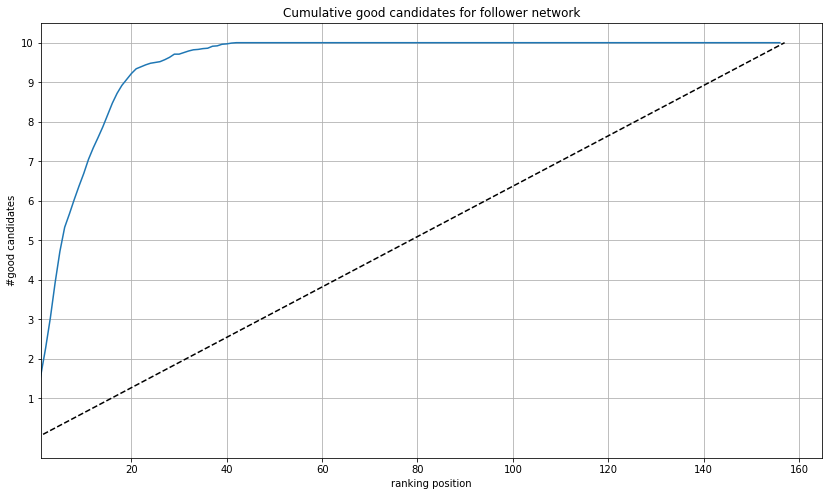

In [18]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_follower_nodes.csv'.format(test), sep='\t', dtype={'id_user':int, 
                                                                                                'followers': float,
                                                                                                'following': float,
                                                                                                'id':int})
data = pd.read_csv(path+'social_network_{}_follower.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_follower, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'follower')

In [52]:
allresult = []
for id_user in all_ranking:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_ranking[id_user]))
    ))

In [53]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if str(x['id_user']) in allseeds else 'random', axis=1)

In [54]:
df_all

,id_user,screen_name,ranking,member
15,241709263,economistmeg,1.770833,seed
14,36499730,kathylienfx,1.857143,seed
11,327577091,justinwolfers,2.032258,seed
24,78013,jennythomasson,2.880000,random
1,211106542,dsquareddigest,3.796610,seed
12,6361512,fgoria,4.140351,seed
7,35810531,bill_easterly,4.170732,seed
18,57268394,katie_martin_fx,5.195652,seed
9,397489668,rencapman,5.645833,seed
16,372460791,reinman_mt,6.081633,seed


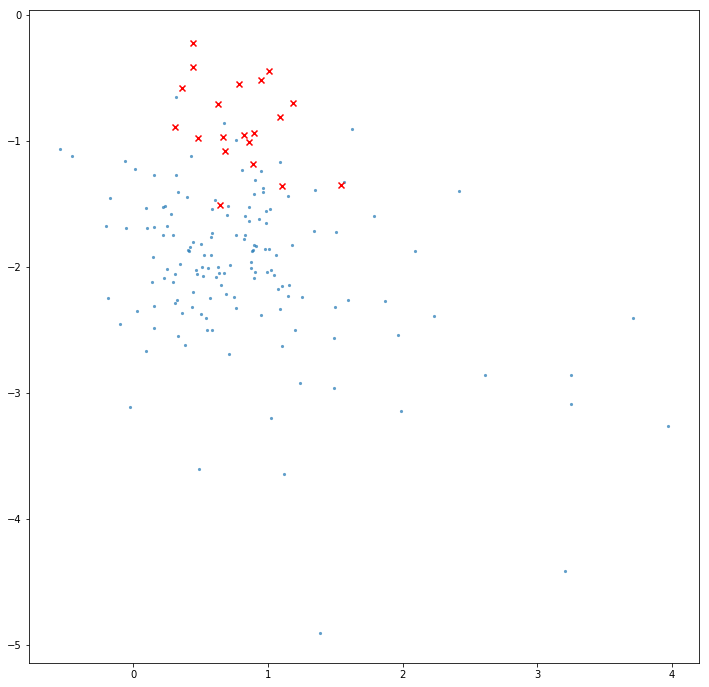

In [56]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

Image to condense all the performances

In [22]:
print (len(perf_tag), len(perf_mention), len(perf_following), len(perf_follower))

168 168 160 157


In [26]:
pf_1 = np.append(perf_following, [10.,10.,10.,10.,10.,10.,10.,10.])

In [27]:
pf_2 = np.append(perf_follower, [10.,10.,10.,10.,10.,10.,10.,10.,10.,10.,10.])

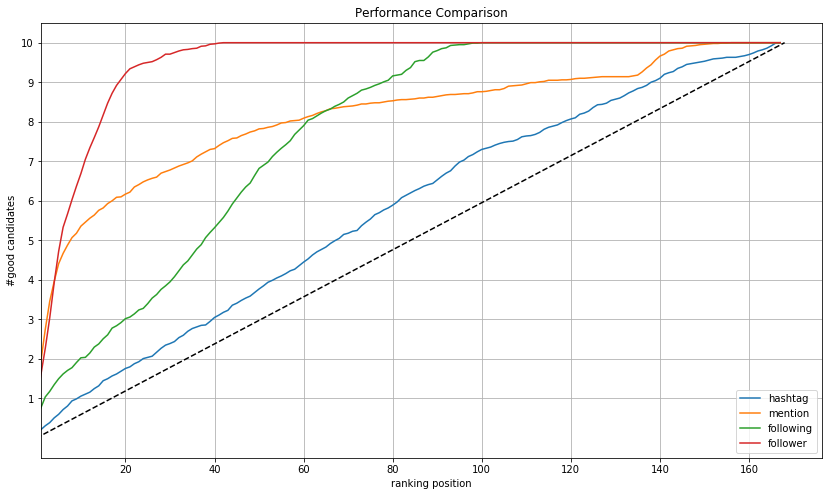

In [30]:
plt.figure(figsize=(14,8))

plt.plot(perf_tag, label='hashtag')
plt.plot(perf_mention, label='mention')
plt.plot(pf_1, label='following')
plt.plot(pf_2, label='follower')
plt.plot([0, len(perf_tag)], [0, 10], linestyle='--', color='black')

plt.legend()
plt.title('Performance Comparison')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.xlim(xmin=1)
plt.yticks(range(1,11))
plt.grid(True)